In [6]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from models.resnet34_yolo import resnet34_yolo as used_model
import config
from torch.utils.data import DataLoader
import pandas as pd

from utils import (
    mean_average_precision,
    get_bboxes,
)

In [7]:
from config import Config

cfg = Config().replace(
    EPOCHS=200,
    BATCH_SIZE=16,
    multiples_to_log_train_map=10,
    DATASET_PATH='../downloads/sampah_uas/train',
    anns_file_path='../downloads/sampah_uas/train/_annotations.coco.json',
    VAL_DATASET_PATH='../downloads/sampah_uas/valid',
    val_anns_file_path='../downloads/sampah_uas/valid/_annotations.coco.json',
    TEST_DATASET_PATH='../downloads/sampah_uas/test',
    test_anns_file_path='../downloads/sampah_uas/test/_annotations.coco.json',
)

In [8]:
folder = "../runs/ResNet/dropout-0.1/2023-19-12_19-19-01"
path_to_model = folder + "/model.pt"
dropout = 0.1

model = used_model(split_size=cfg.SPLIT_SIZE, num_boxes=cfg.NUM_BOXES, num_classes=cfg.NUM_CLASSES, dropout_percentage=cfg.DROPOUT).to(cfg.DEVICE)
model.load_state_dict(torch.load(path_to_model, map_location=torch.device(cfg.DEVICE)))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
IMAGE_SIZE = 448

data_preprocess = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
)

In [10]:
from taco_dataset import CoCoDatasetForYOLO

test_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=cfg.IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=cfg.IMAGE_SIZE, min_width=cfg.IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
)

test_dataset = CoCoDatasetForYOLO(
    root=cfg.TEST_DATASET_PATH,
    annFile=cfg.test_anns_file_path,
    transform=test_transforms,
    S=cfg.SPLIT_SIZE, B=cfg.NUM_BOXES, C=cfg.NUM_CLASSES
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=cfg.BATCH_SIZE,
    num_workers=cfg.NUM_WORKERS,
    pin_memory=cfg.PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [11]:
with torch.no_grad():
    pred_boxes, target_boxes = get_bboxes(
        test_loader, model, iou_threshold=cfg.iou_threshold, threshold=cfg.threshold, device=cfg.DEVICE,
        S=cfg.SPLIT_SIZE, B=cfg.NUM_BOXES, C=cfg.NUM_CLASSES
    )

Class: 0
TP: 67.0
FP: 47.0

True boxes: 144

Recall: 0.4652777910232544
Precision: 0.5877193212509155


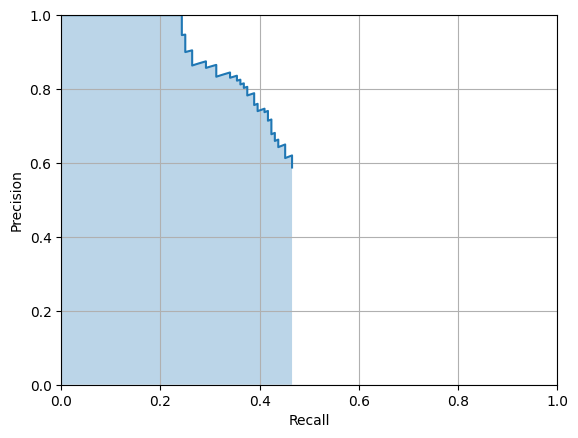

tensor(0.4196)


In [12]:
mean_avg_prec = mean_average_precision(
    pred_boxes, target_boxes, iou_threshold=cfg.iou_threshold, box_format=cfg.box_format, num_classes=cfg.NUM_CLASSES, print_output=True
)

print(mean_avg_prec)